# Figure 4. Inverted processing
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-12-01.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201201/


In [4]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from scipy.stats import mannwhitneyu, sem, ttest_ind, spearmanr
from collections import defaultdict, Counter
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [6]:
s1 = pd.read_csv('supplementary/201123_s1__DROSHA_dependency.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201123_s2__Construct.csv', header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/201123_s3__DROSHA_processing_result.csv', header=1, index_col=0)
s4 = pd.read_csv('supplementary/201123_s4__MiRNA_features.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201123_s6__Inverted_processing.csv', header=1, index_col=0)
#s6 = pd.read_csv('supplementary/201028_s6_cleavage-patterns.csv', header=1, index_col=0)

In [7]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [8]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [9]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
print len(drodep), len(droind), len(droko), len(fclip)

304 257 157 281


In [10]:
EFFCUT = 2.5
HOMCUT = .25
effs = s3['Cleavage Efficiency'].to_dict()
homs = s3['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s3.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s3.index if m not in dcsmirs ]
print len(s3.index), len(dcsmirs), len(nodcs)

1816 534 1282


In [11]:
clvraw = pd.read_csv('supplementary/201012_s4_cleavage-product.csv',header=1,index_col=[0,1,2])
clvtbl = pd.DataFrame()
for lib in LIBRARIES:
    clvtbl[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvtbl = clvtbl.reset_index()
clvtbl.head(1)

,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4,4,0,0,0


In [12]:
START, MID, END = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==START)&(clvtbl['rend']<MID)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>MID)&(clvtbl['rend']==END)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<MID)&(clvtbl['rend']>MID)]
clvn5 = clvhn[clvhn['rstart']==START]
clvn3 = clvhn[clvhn['rend']==END]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [13]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in s2.index if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [14]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

---

## C. Reproducibility of inverted processing

In [15]:
def get_clv_cnts(mir, lib):
    ps, pe = preposition[mir]
    if ps<=0 or pe>=125:
        return -1,-1
    invs = ps+INVERTED
    inve = pe-INVERTED
    clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
    clv3 = clv3f.loc[[mir]].reset_index().set_index('rstart')[lib]
    prod5 = clv5.reindex(range(ps-1-WINDOW,ps+WINDOW)).sum()
    prod3 = clv3.reindex(range(pe+1-WINDOW,pe+2+WINDOW)).sum()
    inv5 = clv5.reindex(range(invs-1-WINDOW,invs+WINDOW)).sum()
    inv3 = clv3.reindex(range(inve+1-WINDOW,inve+2+WINDOW)).sum()
    return int((prod5+prod3)/2), int((inv5+inv3)/2)

In [ ]:
hpn = clvh.loc[[mir]]
    hpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()

In [16]:
S1, S2 = 'set1','set2'
RCUTOFFH = 10
WINDOW = 3
INVERTED = 11
inv = {}
for mir in s2.index:
    ps,pe = preposition[mir]
    hpn = clvh.loc[[mir]]
    phpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                      (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    ihpn = hpn[hpn.apply(lambda x:(x['rstart'] in range(ps+INVERTED-WINDOW,ps+INVERTED+WINDOW+1))
                and (x['rend'] in range(pe-INVERTED-WINDOW,pe-INVERTED+WINDOW+1)),axis=1)].sum()
    if phpn[S1].sum()>=RCUTOFFH and phpn[S2].sum()>=RCUTOFFH:
        inv[mir] = ((ihpn[S1].sum()+1)/(phpn[S1].sum()+1),
                    (ihpn[S2].sum()+1)/(phpn[S2].sum()+1))
print len(inv)

802


In [44]:
np.log2(inv['hsa-let-7c'])

array([6.33161952, 4.92904701])

In [45]:
np.log2(inv['hsa-mir-147b'])

array([6.64217983, 5.1733316 ])

In [17]:
xs, ys = zip(*inv.values())
r = spearmanr(xs, ys)[0]
xs = np.log2(xs)
ys = np.log2(ys)
print r

0.9276409813792033


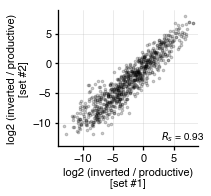

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=7, color='k', alpha=.2, zorder=2, rasterized=True)

ax.set_xlabel('log2 (inverted / productive)\n[set #1]')
ax.set_ylabel('log2 (inverted / productive)\n[set #2]')
ax.set_xticks(range(-10,10,5))
ax.set_yticks(range(-10,10,5))
ax.set_xlim(-14,9)
ax.set_ylim(-14,9)

ax.grid(ls='-',lw=.5)
ax.text(10,-13,'$R_s$ = %.2f'%r,ha='right')
fig.savefig(resultpath + '201201_f4c__inv_meta.pdf',dpi=300)

## D. Comparison with fCLIP-seq

In [46]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')&
                     (fclip293t['Group3p']!='Unidentified')]
both293t.iloc[:1, :8]

,Group5p,Group3p,Overhang,miRBaseOverhang,Contig,Strand,mirBasePosition5p,fCLIPPosition5p
miRNA,,,,,,,,
hsa-let-7a-1,Matched site,Matched site,1.0,1.0,chr9,+,94175962.0,94175962


In [47]:
bedcols = [ 'chr', 'start', 'end', 'miRNA', 'strand' ]
bedfile = 'supplementary/fCLIP/293T/293T_191115_genome-annot_1881-pris_mp1_sp1.bed.gz'
ftbl = pd.read_table(gzip.open(bedfile,'rb'),usecols=[0,1,2,15,17],names=bedcols)
ftbl['start']=ftbl['start']+1
ftbl.head(1)

,chr,start,end,miRNA,strand
0,chr1,17311,17415,hsa-mir-6859-1,-


In [48]:
FCLIPCUT = 5
finv = {}
for mir, row in both293t.iterrows():
    c5,c3,strand = row[['fCLIPPosition5p','fCLIPPosition3p','Strand']].astype(str)
    if c5.find(';')>=0 or c3.find(';')>=0:
        continue
    c5 = int(c5)
    c3 = int(c3)
    sub = ftbl[ftbl['miRNA']==mir]
    if strand=='+':
        premir = sub[(sub['start']==c5)&(sub['end']==c3)]
        if len(premir)>=FCLIPCUT:
            invmir = sub[(abs(sub['start']-c5-INVERTED)<=WINDOW)&
                         (abs(c3-sub['end']-INVERTED)<=WINDOW)]
            finv[mir] = (len(invmir),len(premir))
    else:
        premir = sub[(sub['start']==c3)&(sub['end']==c5)]
        if len(premir)>=FCLIPCUT:
            invmir = sub[(abs(sub['start']-c3-INVERTED)<=WINDOW)&
                         (abs(c5-sub['end']-INVERTED)<=WINDOW)]
            finv[mir] = (len(invmir),len(premir))

In [73]:
mir = 'hsa-mir-1908'
ps, pe = preposition[mir]
hpn = clvh.loc[[mir]]
phpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
ihpn = hpn[hpn.apply(lambda x:(x['rstart'] in range(ps+INVERTED-WINDOW,ps+INVERTED+WINDOW+1))
            and (x['rend'] in range(pe-INVERTED-WINDOW,pe-INVERTED+WINDOW+1)),axis=1)].sum()
print ihpn['set1'], phpn['set1'], finv[mir]

35641 315 (1, 11)


In [49]:
sub = ftbl[ftbl['miRNA']==mir]
c5,c3,strand = both293t.loc[mir,['fCLIPPosition5p','fCLIPPosition3p','Strand']].astype(str)
c5 = int(c5)
c3 = int(c3)
premir = sub[(sub['start']==c3)&(sub['end']==c5)]
invmir = sub[(abs(sub['start']-c3-INVERTED)<=WINDOW)&
             (abs(c5-sub['end']-INVERTED)<=WINDOW)]
print c5, c3
invmir

51692618 51692677


,chr,start,end,miRNA,strand


In [51]:
finv['hsa-let-7a-1']

(0, 437)

In [52]:
pscnt = .0002
comp = {}
for mir in finv:
    ps, pe = preposition[mir]
    hpn = clvh.loc[[mir]]
    phpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                      (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    ihpn = hpn[hpn.apply(lambda x:(x['rstart'] in range(ps+INVERTED-WINDOW,ps+INVERTED+WINDOW+1))
                and (x['rend'] in range(pe-INVERTED-WINDOW,pe-INVERTED+WINDOW+1)),axis=1)].sum()
    if phpn['set1']>=FCLIPCUT:
        comp[mir] = (np.log2(ihpn['set1']/phpn['set1']+pscnt),
                      np.log2(finv[mir][0]/finv[mir][1]+pscnt))
print len(comp)

169


In [54]:
xs, ys = zip(*comp.values())
r, p = spearmanr(xs,ys)
print r, p

-0.01022173423527092 0.8950635716919094


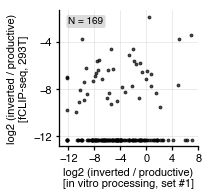

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=8, color='k', alpha=.7, zorder=2, rasterized=True)
ax.set_xlabel('log2 (inverted / productive)\n[in vitro processing, set #1]')
ax.set_ylabel('log2 (inverted / productive)\n[fCLIP-seq, 293T]')
ax.set_xticks(range(-12,9,4))
ax.set_yticks(range(-12,-3,4))
ax.set_xlim(-13.5,8)
ax.grid(ls='-',lw=.5)
ax.text(-12,-2.5,'N = %s'%len(xs),
       bbox={'pad':.2,'color':'#bababa','alpha':.5,'boxstyle':'round','lw':0})
fig.savefig(resultpath + '201123_f4__inverted_fcilp.pdf',dpi=300)

In [58]:
for mir in ['hsa-mir-1908','hsa-mir-147b','hsa-mir-214','hsa-mir-146a','hsa-let-7c']:
    if mir in comp:
        print mir,comp[mir]

hsa-mir-1908 (6.822044727257655, -3.456261175757169)
hsa-let-7c (6.338624696636714, -12.287712379549449)


In [78]:
for m in sorted(comp.keys(),key=lambda x:-comp[x][1]):
    vitro, vivo = comp[m]
    if vitro>-4 and vivo>-6:
        print '%s\t%.2f\t%.2f\t%.2f\t%.2f'%(m, vitro, vivo, effs[m], homs[m])

hsa-mir-4761	0.34	-1.87	4.15	0.52
hsa-mir-1908	6.82	-3.46	0.00	0.06
hsa-mir-455	4.98	-3.80	2.80	0.24
hsa-mir-5001	-2.09	-4.64	0.68	0.29
hsa-mir-374a	-2.65	-5.10	3.82	0.74
hsa-mir-505	-1.82	-5.66	5.01	0.80
hsa-mir-25	-1.04	-5.83	2.48	0.43
hsa-mir-19a	-1.58	-5.87	2.89	0.54


## E. Structures

In [93]:
def list_basal_jcs(infos, minss, lastunp, init): # [ (1, 124), (2, 123), ... ]
    jcpos, dist = [], init
    for uppair, lowpair in zip(infos[:-1], infos[1:]):
        jcsize = abs(uppair[0]-lowpair[0])+abs(lowpair[1]-uppair[1])-2
        jc5 = abs(uppair[0]-lowpair[0])-1
        jc3 = abs(lowpair[1]-uppair[1])-1
        if jcsize>=minss:
            jcpos.append((dist,uppair,jc5,jc3))
        dist += calculate_dist(uppair, lowpair)
    jcpos.append((dist,infos[-1],lastunp))
    return jcpos

In [85]:
strtbl = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)

In [87]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s3.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

534 (25, 96)


In [146]:
basalsegs = {}
for mir in s5.index:
    if mir in dcsmirs:
        cs, ce = majorcs[mir]
    else:
        cs, ce = preposition[mir]
    stinfo = [ (int(i),pair) for i,pair in strtbl.iloc[:,:125].loc[mir].items() ]
    lsinfo = [ (s,e) for s,e in stinfo if s<cs<e ][::-1]
    if not lsinfo:
        continue
    ls1st5, ls1st3 = lsinfo[0]
    us1st3 = [ (s,e) for s,e in stinfo if cs<=s<e ][0][1]
    init = min(cs-ls1st5, ls1st3-us1st3)
    bj = min(list_basal_jcs(lsinfo, 1, 3.5, init)[::-1],key=lambda x:abs(x[0]-13))
    basalsegs[mir] = bj[2:]

In [21]:
highinv = s6.sort_values('Inverted processing').index[-100:]
lowinv = s6.sort_values('Inverted processing').index[:100]

In [155]:
data5 = [[ basalsegs[m][0] for m in highinv if m in basalsegs and len(basalsegs[m])>=2], 
         [ basalsegs[m][0] for m in lowinv if m in basalsegs and len(basalsegs[m])>=2 ] ]
data3 = [[ basalsegs[m][1] for m in highinv if m in basalsegs and len(basalsegs[m])>=2 ], 
         [ basalsegs[m][1] for m in lowinv if m in basalsegs and len(basalsegs[m])>=2 ] ]
data = [[ sum(basalsegs[m]) for m in highinv if m in basalsegs and len(basalsegs[m])>=2 ], 
         [ sum(basalsegs[m]) for m in lowinv if m in basalsegs and len(basalsegs[m])>=2 ] ]

In [156]:
print ttest_ind(data5[0],data5[1],equal_var=False)
print ttest_ind(data3[0],data3[1],equal_var=False)
print ttest_ind(data[0],data[1],equal_var=False)

Ttest_indResult(statistic=-0.9995508003695721, pvalue=0.31897839663748523)
Ttest_indResult(statistic=-2.5418133405980416, pvalue=0.012095889408093103)
Ttest_indResult(statistic=-2.313775766829623, pvalue=0.022049830346089358)


In [192]:
xs = range(1, 25)
bins = np.arange(1,26)-.5
vs,ts = np.histogram(data3[0],bins=bins)
ys1 = vs.cumsum()/vs.sum()
vs,ts = np.histogram(data3[1],bins=bins)
ys2 = vs.cumsum()/vs.sum()
colors = '#fd8d3c #757575'.split()

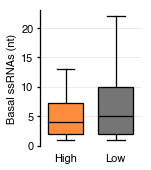

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(1.8,2.5))
bp = ax.boxplot(data,widths=.7,sym='',boxprops={'linewidth':1.3},
                medianprops={'color':'black','linewidth':1.3}, capprops={'linewidth':1.3},
                whiskerprops={'linewidth':1.3}, patch_artist=True,zorder=2)
for box,c in zip(bp['boxes'],colors):
    box.set_facecolor(c)

ax.set_xticks([1,2])
ax.set_xticklabels(['High','Low'])
#ax.set_xticklabels(['Processed\n(n=%s)'%len(data[0]),
#                    'The rest\n(n=%s)'%len(data[1])],fontsize=11)
ax.set_ylabel('Basal ssRNAs (nt)',fontsize=11)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom='off')
ax.yaxis.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '201123_f4e__inverted_feature.pdf')

## S4A. Sequence motifs

In [8]:
motifs = [ 'CNNC', 'UG', 'GHG', 'UGU' ]
motmirs = {}
for motif in motifs:
    ml = open('resources/201118_%s.txt'%motif,'rt').read().split('\n')
    motmirs[motif] = ml
    print motif, len(ml)

CNNC 617
UG 248
GHG 656
UGU 455


In [29]:
mirls = [ motmirs[motif] for motif in motifs[1:] ]
print len(mirls)

3


In [30]:
xs = np.arange(3)
ls = ['UG','mGHG','UGU/G']
ys1,ys2 = [],[]
for ml in mirls:
    ys1.append(len([m for m in ml if m in highinv]))
    ys2.append(len([m for m in ml if m in lowinv]))
ys = np.array(ys1)/np.array(ys2)

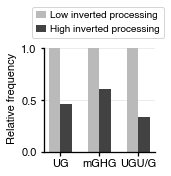

In [37]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.bar(xs-.15,[1,1,1],color='#bababa',width=.3,lw=0,label='Low inverted processing',zorder=2)
ax.bar(xs+.15,ys,color='#424242',width=.3,lw=0,label='High inverted processing',zorder=2)
ax.set_ylabel('Relative frequency')
ax.set_xticks(xs)
ax.set_xticklabels(ls)
ax.yaxis.grid(ls='-',lw=.5)
ax.spines['left'].set_bounds(0,1)
ax.legend(loc=(-.1,1.05), handlelength=1, handletextpad=.4)
fig.savefig(resultpath+'201123_s4a__inverted_processing_feature.pdf')

In [64]:
stls = s4[s4['Stable lower stem']=='O'].index

In [68]:
xs = np.arange(2)
ls = ['Stable\nlower stem','CNNC']
ys1,ys2 = [],[]
for ml in [stls, motmirs['CNNC']]:
    ys1.append(len([m for m in ml if m in highinv]))
    ys2.append(len([m for m in ml if m in lowinv]))
ys = np.array(ys1)/np.array(ys2)

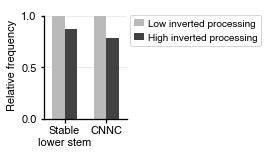

In [74]:
fig, ax = plt.subplots(1,1,figsize=(1.5,2))
ax.bar(xs-.15,[1,1],color='#bababa',width=.3,lw=0,label='Low inverted processing',zorder=2)
ax.bar(xs+.15,ys,color='#424242',width=.3,lw=0,label='High inverted processing',zorder=2)
ax.set_ylabel('Relative frequency')
ax.set_xticks(xs)
ax.set_xticklabels(ls)
ax.set_xlim(-.5,1.5)
ax.yaxis.grid(ls='-',lw=.5)
ax.spines['left'].set_bounds(0,1)
ax.legend(loc=(1.03,.67), handlelength=1, handletextpad=.4)
fig.savefig(resultpath+'201128_s4a__inverted_processing_feature.pdf')